# K Nearest Neighbors Classifier

In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv('../FeatureEngineering/MetaData/data6_&_odds.csv')
df.dropna(inplace=True)

In [17]:
import sys
sys.path.append('C:/Users/spira/OneDrive/Documents/GitHub/BasketDataHub/venv')
from helpers import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

In [18]:
train_data = df.loc[(df.season <= 2013) & (df.season >= 2007)]
valid_data = df.loc[(df.season > 2013) & (df.season < 2016)]
test_data = df.loc[df.season >= 2016]
full_train_data = pd.concat([train_data, valid_data], axis=0)

X_train, y_train = train_data.drop(columns=["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"]), train_data.home_team_wins
X_val, y_val = valid_data.drop(columns=["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"]), valid_data.home_team_wins
X_test, y_test = test_data.drop(columns=["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"]), test_data.home_team_wins


## KNN with GridSearchCV and PCA

In [19]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
trainPCA = pca.fit_transform(X_train)
valPCA = pca.transform(X_val)

In [20]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(trainPCA, y_train)
val_score = estimator.score(X_val, y_val)

preds = estimator.predict(valPCA)
test_score = estimator.score(valPCA, y_val)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 41.432631731033325 seconds
              precision    recall  f1-score   support

   home_loss       0.64      0.54      0.59      1011
    home_win       0.70      0.78      0.74      1409

    accuracy                           0.68      2420
   macro avg       0.67      0.66      0.66      2420
weighted avg       0.68      0.68      0.68      2420

val score: 0.4206611570247934
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.6755072463768116
test score 0.6814049586776859


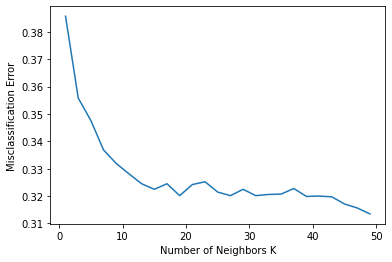

In [21]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, trainPCA, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [22]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(trainPCA, y_train)
pred = knn.predict(valPCA)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.7020661157024793 with k= 49


## Use of StandardScaler

In [11]:
from sklearn.preprocessing import StandardScaler

# Scaling features
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_val_standard = scaler.transform(X_val)
X_test_standard = scaler.transform(X_test)

In [7]:
import time

# Split Data to Train and Validation
# X_train, X_val, y_train, y_val = train_test_split(X_train_standard, y_train, test_size=0.4)
clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_standard, y_train)
val_score = estimator.score(X_val_standard, y_val)

preds = estimator.predict(X_test_standard)
test_score = estimator.score(X_test_standard, y_test)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 46.0059757232666 seconds
              precision    recall  f1-score   support

   home_loss       0.65      0.60      0.62      2290
    home_win       0.73      0.77      0.75      3272

    accuracy                           0.70      5562
   macro avg       0.69      0.69      0.69      5562
weighted avg       0.70      0.70      0.70      5562

val score: 0.6866387058118634
KNeighborsClassifier(leaf_size=1, n_neighbors=14)
{'leaf_size': 1, 'n_neighbors': 14}
best score: 0.6957430273627232
test score 0.7002876663070838


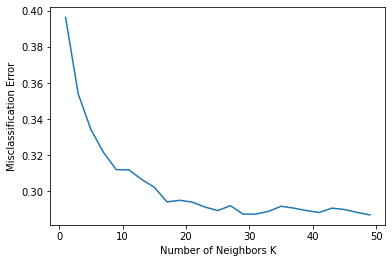

In [10]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_standard, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [11]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_standard, y_train)
pred = knn.predict(X_test_standard)
print("\nOptimal accuracy on the test set is", accuracy_score(y_test, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.718626393383675 with k= 49


## Use of MinMax Scaler

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Scaling features
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_val_minmax = scaler.transform(X_val)
X_test_minmax = scaler.transform(X_test)


In [9]:
import time

# Split Data to Train and Validation
# X_train, X_val, y_train, y_val = train_test_split(X_train_minmax, y_train, test_size=0.4)
clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_minmax, y_train)
val_score = estimator.score(X_val_minmax, y_val)

preds = estimator.predict(X_test_minmax)
test_score = estimator.score(X_test_minmax, y_test)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 42.56228065490723 seconds
              precision    recall  f1-score   support

   home_loss       0.62      0.52      0.56      2290
    home_win       0.70      0.78      0.74      3272

    accuracy                           0.67      5562
   macro avg       0.66      0.65      0.65      5562
weighted avg       0.67      0.67      0.67      5562

val score: 0.6626722588376274
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.6747600357124809
test score 0.6731391585760518


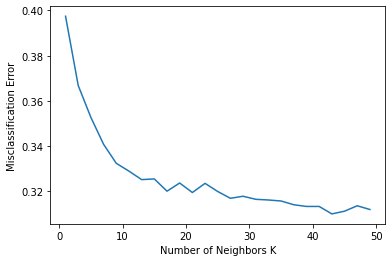

In [12]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_minmax, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [13]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_minmax, y_train)
pred = knn.predict(X_test_minmax)
print("\nOptimal accuracy on the test set is", accuracy_score(y_test, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 43

Optimal accuracy on the test set is 0.6975907946781733 with k= 43


## Univariate Feature Selection

In [5]:
X_train_uni = train_data[['diff_curr_win_pct','diff_curr_away_record','odds_home','odds_away','elo_diff']]
y_train_uni = y_train

X_val_uni = valid_data[['diff_curr_win_pct','diff_curr_away_record','odds_home','odds_away','elo_diff']]
y_val_uni = y_val

In [6]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_uni, y_train_uni)
val_score = estimator.score(X_val_uni, y_val_uni)

preds = estimator.predict(X_val_uni)
test_score = estimator.score(X_val_uni, y_val_uni)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_uni, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 11.406625270843506 seconds
              precision    recall  f1-score   support

   home_loss       0.61      0.54      0.57      1011
    home_win       0.70      0.76      0.72      1409

    accuracy                           0.67      2420
   macro avg       0.65      0.65      0.65      2420
weighted avg       0.66      0.67      0.66      2420

val score: 0.665702479338843
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.6685507246376811
test score 0.665702479338843


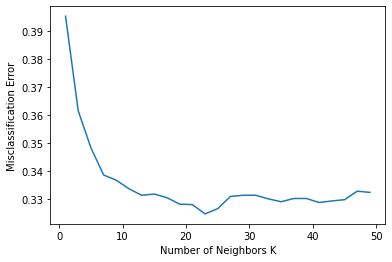

In [7]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_uni, y_train_uni, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [11]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_uni, y_train_uni)
pred = knn.predict(X_val_uni)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_uni, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 23

Optimal accuracy on the test set is 0.671900826446281 with k= 23


## kNN with ExtraTress Classifier

In [21]:
X_train_extra = train_data[['odds_home','odds_away','home_elo','visitor_elo','elo_diff','eff_diff','eff_visitor',
'diff_home_record_last_season','ROAD_RECORD_away','ROAD_RECORD_home','diff_road_record_last_season','diff_win_pct_prev_season','W_PCT_home',
'W_PCT_away','diff_curr_away_record','HOME_RECORD_home','diff_curr_home_record','diff_curr_win_pct']]
y_train_extra = y_train

X_val_extra = valid_data[['odds_home','odds_away','home_elo','visitor_elo','elo_diff','eff_diff','eff_visitor',
'diff_home_record_last_season','ROAD_RECORD_away','ROAD_RECORD_home','diff_road_record_last_season','diff_win_pct_prev_season','W_PCT_home',
'W_PCT_away','diff_curr_away_record','HOME_RECORD_home','diff_curr_home_record','diff_curr_win_pct']]
y_val_extra = y_val

In [22]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_extra, y_train_extra)
val_score = estimator.score(X_val_extra, y_val_extra)

preds = estimator.predict(X_val_extra)
test_score = estimator.score(X_val_extra, y_val_extra)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_extra, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 40.044705629348755 seconds
              precision    recall  f1-score   support

   home_loss       0.63      0.53      0.58      1011
    home_win       0.70      0.77      0.73      1409

    accuracy                           0.67      2420
   macro avg       0.66      0.65      0.66      2420
weighted avg       0.67      0.67      0.67      2420

val score: 0.6727272727272727
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.6563768115942028
test score 0.6727272727272727


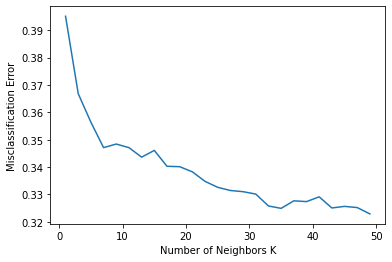

In [23]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_extra, y_train_extra, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [24]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_extra, y_train_extra)
pred = knn.predict(X_val_extra)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_extra, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6921487603305785 with k= 49


## kNN with SelectFromModel(LassoCV)

In [25]:
X_train_sfm = train_data[['eff','diff_curr_win_pct','diff_road_record_last_season','odds_home','W_PCT_prev_away',
'diff_avg_reb_home','ROAD_RECORD_prev_away','diff_avg_pts_home']]
y_train_sfm = y_train

X_val_sfm = valid_data[['eff','diff_curr_win_pct','diff_road_record_last_season','odds_home','W_PCT_prev_away',
'diff_avg_reb_home','ROAD_RECORD_prev_away','diff_avg_pts_home']]
y_val_sfm = y_val

In [26]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_sfm, y_train_sfm)
val_score = estimator.score(X_val_sfm, y_val_sfm)

preds = estimator.predict(X_val_sfm)
test_score = estimator.score(X_val_sfm, y_val_sfm)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_sfm, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 10.0533127784729 seconds
              precision    recall  f1-score   support

   home_loss       0.52      0.33      0.41      1011
    home_win       0.62      0.78      0.69      1409

    accuracy                           0.59      2420
   macro avg       0.57      0.56      0.55      2420
weighted avg       0.58      0.59      0.57      2420

val score: 0.5933884297520661
KNeighborsClassifier(leaf_size=1, n_neighbors=11)
{'leaf_size': 1, 'n_neighbors': 11}
best score: 0.5840579710144927
test score 0.5933884297520661


In [27]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_sfm, y_train_sfm)
pred = knn.predict(X_val_sfm)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_sfm, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6119834710743801 with k= 49


## kNN with Sequential Feature Selection

### Forward

In [28]:
X_train_for_sfs = train_data[['num_possible_outcomes','HG_7days_VISITOR','Home_Last_5_Avg_PTS_home',
'Home_Last_5_Avg_FG3_PCT_home','Home_Last_5_Avg_FG3_PCT_away','Home_Last_5_Avg_AST_home','Away_Last_5_Avg_FG3_PCT_home',
'Away_Last_5_Avg_FG_PCT_home','Away_Last_5_Avg_FG_PCT_away','Away_Last_5_Avg_PTS_home','Away_Last_5_Avg_AST_away',
'Away_Last_5_Avg_REB_home','Away_Last_5_Avg_REB_away','odds_away','diff_avg_pts_home','diff_avg_fg3_pct_away',
'diff_avg_reb_home','G_home','HOME_RECORD_away','WIN_PRCT_home_3g','PTS_home_3g','FT_PCT_home_3g','REB_home_3g',
'PTS_away_3g','FG_PCT_away_3g','FG3_PCT_away_3g','WIN_PRCT_home_7g','PTS_home_7g','FT_PCT_home_7g','AST_home_7g','REB_home_7g',
'PTS_away_7g','FG_PCT_away_7g','FT_PCT_away_7g','FG3_PCT_away_7g','REB_away_7g','diff_avg_fg3_pct_home','diff_avg_ft_pct_home',
'diff_avg_ft_pct_away','top_players_visitor','eff','missing_player_diff','month','diff_pts_last_3_games','diff_ft_pct_last_7_games',
'diff_ast_last_3_games','diff_reb_last_7_games','diff_win_pct_prev_season','diff_curr_win_pct','diff_curr_away_record']]
y_train_for_sfs = y_train

X_val_for_sfs = valid_data[['num_possible_outcomes','HG_7days_VISITOR','Home_Last_5_Avg_PTS_home',
'Home_Last_5_Avg_FG3_PCT_home','Home_Last_5_Avg_FG3_PCT_away','Home_Last_5_Avg_AST_home','Away_Last_5_Avg_FG3_PCT_home',
'Away_Last_5_Avg_FG_PCT_home','Away_Last_5_Avg_FG_PCT_away','Away_Last_5_Avg_PTS_home','Away_Last_5_Avg_AST_away',
'Away_Last_5_Avg_REB_home','Away_Last_5_Avg_REB_away','odds_away','diff_avg_pts_home','diff_avg_fg3_pct_away',
'diff_avg_reb_home','G_home','HOME_RECORD_away','WIN_PRCT_home_3g','PTS_home_3g','FT_PCT_home_3g','REB_home_3g',
'PTS_away_3g','FG_PCT_away_3g','FG3_PCT_away_3g','WIN_PRCT_home_7g','PTS_home_7g','FT_PCT_home_7g','AST_home_7g','REB_home_7g',
'PTS_away_7g','FG_PCT_away_7g','FT_PCT_away_7g','FG3_PCT_away_7g','REB_away_7g','diff_avg_fg3_pct_home','diff_avg_ft_pct_home',
'diff_avg_ft_pct_away','top_players_visitor','eff','missing_player_diff','month','diff_pts_last_3_games','diff_ft_pct_last_7_games',
'diff_ast_last_3_games','diff_reb_last_7_games','diff_win_pct_prev_season','diff_curr_win_pct','diff_curr_away_record']]
y_val_for_sfs = y_val


In [29]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_for_sfs, y_train_for_sfs)
val_score = estimator.score(X_val_for_sfs, y_val_for_sfs)

preds = estimator.predict(X_val_for_sfs)
test_score = estimator.score(X_val_for_sfs, y_val_for_sfs)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_for_sfs, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 37.975773096084595 seconds
              precision    recall  f1-score   support

   home_loss       0.52      0.35      0.42      1011
    home_win       0.62      0.77      0.69      1409

    accuracy                           0.59      2420
   macro avg       0.57      0.56      0.55      2420
weighted avg       0.58      0.59      0.57      2420

val score: 0.5921487603305785
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.588840579710145
test score 0.5921487603305785


In [30]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_for_sfs, y_train_for_sfs)
pred = knn.predict(X_val_for_sfs)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_for_sfs, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.618595041322314 with k= 49


### Backwards

In [31]:
X_train_back_sfs = train_data[['num_possible_outcomes','G_7days','HG_7days','AG_7days','HG_7days_VISITOR',
'Home_Last_5_Avg_FG_PCT_home','Home_Last_5_Avg_FT_PCT_home','Home_Last_5_Avg_FG3_PCT_home','Home_Last_5_Avg_REB_away',
'Away_Last_5_Avg_FG3_PCT_home','Away_Last_5_Avg_FT_PCT_home','Away_Last_5_Avg_FG_PCT_away','Away_Last_5_Avg_PTS_home',
'Away_Last_5_Avg_AST_away','Away_Last_5_Avg_REB_away','HOME_RECORD_away','HOME_RECORD_home','ROAD_RECORD_away','HOME_RECORD_prev_home',
'HOME_RECORD_prev_away','FG3_PCT_home_3g','FT_PCT_home_7g',
'REB_home_7g','diff_avg_fg_pct_home','diff_avg_reb_away','top_players',
'FT_PCT_away_7g','REB_away_7g','diff_avg_fg3_pct_home','diff_avg_ft_pct_home',
'top_players_visitor','eff','eff_visitor','eff_diff','missing_player_diff','month','diff_pts_last_3_games',
'diff_ft_pct_last_7_games','missing_players','missing_players_visitor','top_player_diff','diff_fg3_pct_last_3_games','diff_ast_last_7_games',
'diff_ast_last_3_games','diff_reb_last_7_games','diff_win_pct_prev_season','diff_road_record_last_season','diff_curr_home_record']]
y_train_back_sfs = y_train

X_val_back_sfs = valid_data[['num_possible_outcomes','G_7days','HG_7days','AG_7days','HG_7days_VISITOR',
'Home_Last_5_Avg_FG_PCT_home','Home_Last_5_Avg_FT_PCT_home','Home_Last_5_Avg_FG3_PCT_home','Home_Last_5_Avg_REB_away',
'Away_Last_5_Avg_FG3_PCT_home','Away_Last_5_Avg_FT_PCT_home','Away_Last_5_Avg_FG_PCT_away','Away_Last_5_Avg_PTS_home',
'Away_Last_5_Avg_AST_away','Away_Last_5_Avg_REB_away','HOME_RECORD_away','HOME_RECORD_home','ROAD_RECORD_away','HOME_RECORD_prev_home',
'HOME_RECORD_prev_away','FG3_PCT_home_3g','FT_PCT_home_7g',
'REB_home_7g','diff_avg_fg_pct_home','diff_avg_reb_away','top_players',
'FT_PCT_away_7g','REB_away_7g','diff_avg_fg3_pct_home','diff_avg_ft_pct_home',
'top_players_visitor','eff','eff_visitor','eff_diff','missing_player_diff','month','diff_pts_last_3_games',
'diff_ft_pct_last_7_games','missing_players','missing_players_visitor','top_player_diff','diff_fg3_pct_last_3_games','diff_ast_last_7_games',
'diff_ast_last_3_games','diff_reb_last_7_games','diff_win_pct_prev_season','diff_road_record_last_season','diff_curr_home_record']]
y_val_back_sfs = y_val

In [32]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_back_sfs, y_train_back_sfs)
val_score = estimator.score(X_val_back_sfs, y_val_back_sfs)

preds = estimator.predict(X_val_back_sfs)
test_score = estimator.score(X_val_back_sfs, y_val_back_sfs)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_back_sfs, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 39.06390595436096 seconds
              precision    recall  f1-score   support

   home_loss       0.57      0.42      0.49      1011
    home_win       0.65      0.77      0.71      1409

    accuracy                           0.63      2420
   macro avg       0.61      0.60      0.60      2420
weighted avg       0.62      0.63      0.61      2420

val score: 0.6260330578512396
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.6079710144927537
test score 0.6260330578512396


In [33]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_back_sfs, y_train_back_sfs)
pred = knn.predict(X_val_back_sfs)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_back_sfs, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6355371900826446 with k= 49


## kNN with RFE

In [34]:
X_train_rfe = train_data[['num_possible_outcomes', 'odds_home', 'odds_away','G_home', 'W_PCT_home', 'HOME_RECORD_home',
       'ROAD_RECORD_home', 'G_away', 'W_PCT_away', 'ROAD_RECORD_away',
       'W_PCT_prev_home', 'ROAD_RECORD_prev_home', 'W_PCT_prev_away',
       'HOME_RECORD_prev_away', 'ROAD_RECORD_prev_away', 'AST_home_3g',
       'REB_home_3g', 'WIN_PRCT_away_3g', 'PTS_away_3g', 'FG3_PCT_away_3g',
       'AST_home_7g', 'REB_home_7g', 'PTS_away_7g', 'AST_away_7g',
       'diff_avg_pts_home', 'diff_avg_pts_away', 'diff_avg_ast_home',
       'diff_avg_fg3_pct_home', 'diff_avg_reb_home', 'diff_avg_reb_away',
       'top_players', 'HG_7days', 'AG_7days', 'G_7days', 'HG_7days_VISITOR',
       'back2back_visitor', 'missing_players', 'missing_players_visitor',
       'top_player_diff', 'missing_player_diff', 'month',
       'Home_Last_5_Avg_AST_home', 'Home_Last_5_Avg_REB_home',
       'Home_Last_5_Avg_PTS_away', 'Home_Last_5_Avg_FT_PCT_away',
       'Home_Last_5_Avg_REB_away', 'Home_Last_5_Avg_AST_away',
       'Away_Last_5_Avg_REB_home', 'Away_Last_5_Avg_REB_away',
       'Away_Last_5_Avg_AST_away', 'diff_pts_last_3_games',
       'diff_fg3_pct_last_3_games', 'diff_ft_pct_last_3_games',
       'diff_ast_last_3_games', 'diff_ast_last_7_games',
       'diff_reb_last_7_games', 'diff_win_pct_3_last_games',
       'diff_curr_win_pct', 'diff_curr_home_record']]
y_train_rfe = y_train

X_val_rfe = valid_data[['num_possible_outcomes', 'odds_home', 'odds_away','G_home', 'W_PCT_home', 'HOME_RECORD_home',
       'ROAD_RECORD_home', 'G_away', 'W_PCT_away', 'ROAD_RECORD_away',
       'W_PCT_prev_home', 'ROAD_RECORD_prev_home', 'W_PCT_prev_away',
       'HOME_RECORD_prev_away', 'ROAD_RECORD_prev_away', 'AST_home_3g',
       'REB_home_3g', 'WIN_PRCT_away_3g', 'PTS_away_3g', 'FG3_PCT_away_3g',
       'AST_home_7g', 'REB_home_7g', 'PTS_away_7g', 'AST_away_7g',
       'diff_avg_pts_home', 'diff_avg_pts_away', 'diff_avg_ast_home',
       'diff_avg_fg3_pct_home', 'diff_avg_reb_home', 'diff_avg_reb_away',
       'top_players', 'HG_7days', 'AG_7days', 'G_7days', 'HG_7days_VISITOR',
       'back2back_visitor', 'missing_players', 'missing_players_visitor',
       'top_player_diff', 'missing_player_diff', 'month',
       'Home_Last_5_Avg_AST_home', 'Home_Last_5_Avg_REB_home',
       'Home_Last_5_Avg_PTS_away', 'Home_Last_5_Avg_FT_PCT_away',
       'Home_Last_5_Avg_REB_away', 'Home_Last_5_Avg_AST_away',
       'Away_Last_5_Avg_REB_home', 'Away_Last_5_Avg_REB_away',
       'Away_Last_5_Avg_AST_away', 'diff_pts_last_3_games',
       'diff_fg3_pct_last_3_games', 'diff_ft_pct_last_3_games',
       'diff_ast_last_3_games', 'diff_ast_last_7_games',
       'diff_reb_last_7_games', 'diff_win_pct_3_last_games',
       'diff_curr_win_pct', 'diff_curr_home_record']]
y_val_rfe = y_val

In [35]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train_rfe, y_train_rfe)
val_score = estimator.score(X_val_rfe, y_val_rfe)

preds = estimator.predict(X_val_rfe)
test_score = estimator.score(X_val_rfe, y_val_rfe)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_val_rfe, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)

Συνολικός χρόνος fit και predict: 38.843665599823 seconds
              precision    recall  f1-score   support

   home_loss       0.53      0.39      0.45      1011
    home_win       0.63      0.75      0.68      1409

    accuracy                           0.60      2420
   macro avg       0.58      0.57      0.57      2420
weighted avg       0.59      0.60      0.59      2420

val score: 0.5979338842975207
KNeighborsClassifier(leaf_size=1, n_neighbors=11)
{'leaf_size': 1, 'n_neighbors': 11}
best score: 0.5995652173913043
test score 0.5979338842975207


In [36]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train_rfe, y_train_rfe)
pred = knn.predict(X_val_rfe)
print("\nOptimal accuracy on the test set is", accuracy_score(y_val_rfe, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 49

Optimal accuracy on the test set is 0.6161157024793389 with k= 49
